In [1]:
from huggingface_hub import HfApi
import pandas as pd
import itertools
import re
import requests
from bs4 import BeautifulSoup
import time
import json
import os
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

sns.set(style="white", font_scale=2)

from tags import * # tags.py

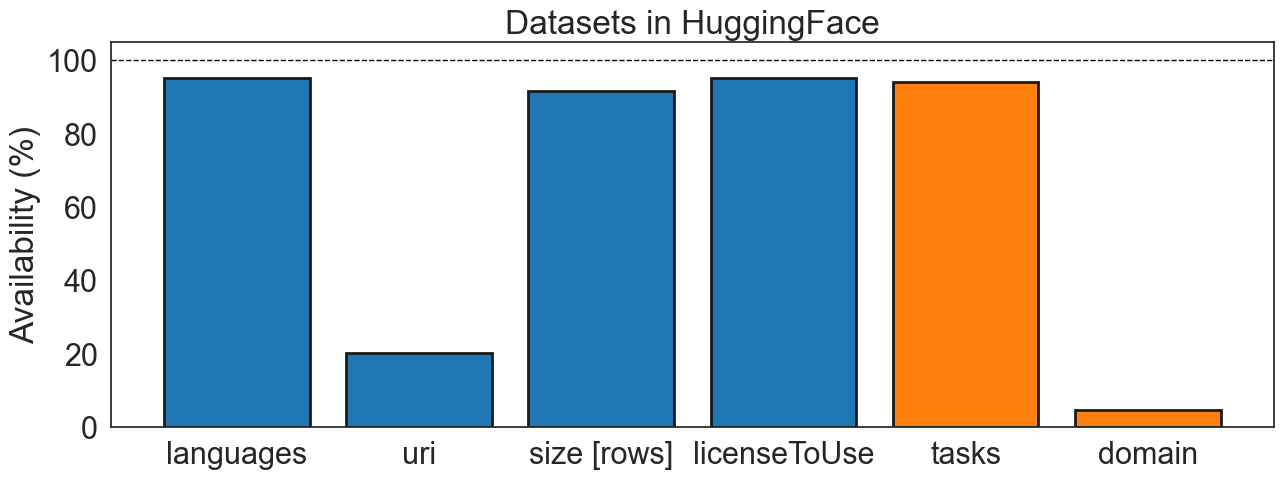

In [90]:
datasets = json.load(open("../database/HF entries/hf extracted json/datasets.json", "r"))
df = pd.DataFrame(datasets, dtype=str)
L = df.__len__()

cols = ["languages", "uri", "size [rows]", "licenseToUse"] + ["tasks", "domain"]

df = df.replace("[]", None)

values = []
for col in cols:
    x = df[(df[col].isna())].__len__()
    values.append(100 - x/L * 100)

plt.figure(figsize=(15, 5))   
plt.bar(x=range(cols.__len__()), height = values, color = ['tab:blue' for j in range(4)] + ['tab:orange' for j in range(2)], edgecolor="k", linewidth=2)
plt.title("Datasets in HuggingFace")
plt.ylabel("Availability (%)")
plt.axhline(100, ls="--", color="black", linewidth=1)
plt.xticks(range(cols.__len__()), cols)
plt.show()



In [91]:
models = json.load(open("../database/HF entries/hf extracted json/models_new.json", "r"))
df = pd.DataFrame(models, dtype=str)

df = df.replace("[]", None)

L = df.__len__()

hf_api_cols = [
       'languages', 'modelCreator', 'libraryFramework', 'uri',
       'carbonEmission [CO2eq tons]']

hf_derived_cols = ['licenseToUse', 'quantization', 'architecture', 'fineTuned']

new_cols = ['numberOfParameters', "tokenizer", "developers", "contextLength", "version"]
# 'tokenizer', 'likes', 'downloads',
#       'tasks', 'dataset', 'metrics']

cols = hf_api_cols + hf_derived_cols


([<matplotlib.axis.XTick at 0x30ad89330>,
 [Text(0, 0, 'languages'),
  Text(1, 0, 'modelCreator'),
  Text(2, 0, 'libraryFramework'),
  Text(3, 0, 'uri'),
  Text(4, 0, 'carbonEmission [CO2eq tons]'),
  Text(5, 0, 'licenseToUse'),
  Text(6, 0, 'quantization'),
  Text(7, 0, 'architecture'),
  Text(8, 0, 'fineTuned')])

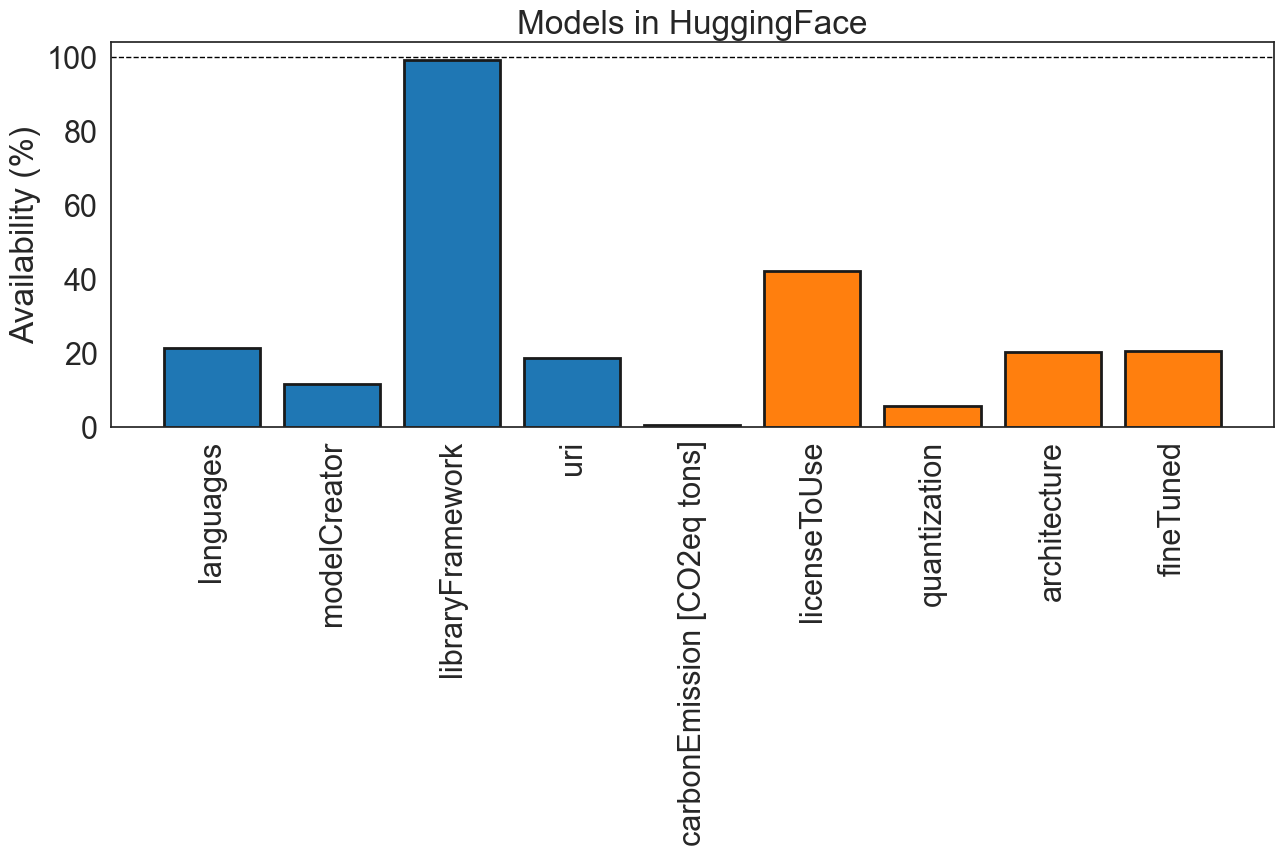

In [92]:
values = []
for col in cols:
    x = df[df[col].isna()].__len__()
    values.append(100 - x/L * 100)

plt.figure(figsize=(15, 5))   
plt.bar(x=range(cols.__len__()), height = values, edgecolor="k", color = ['tab:blue' for j in range(5)] + ['tab:orange' for j in range(5)], linewidth=2)
plt.title("Models in HuggingFace")
plt.ylabel("Availability (%)")
plt.axhline(100, ls="--", color="black", linewidth=1)
plt.xticks(range(cols.__len__()), cols, rotation=90)

In [93]:
values = []
for _, row in df.iterrows():
    missing = 0
    for col in cols:
        if not row[col]:
            missing += 1
    values.append(missing)

In [94]:
new_df = pd.DataFrame()
new_df["missing"] = values
new_df["available"] = 100 - new_df.missing/10 * 100
new_df["likes"] = df.likes.astype(int)
new_df["downloads"] = df.downloads.astype(int)
for col in ["likes", "downloads"]:
    bins = np.percentile(new_df[col], [0, 90, 95, 99, 100])
    # bins = [-1, 0, 1, 10, 100, np.max(new_df[col])]
    new_df[col+"_binned"] = pd.cut(new_df[col], bins = bins)
new_df["developers"] = df.developers

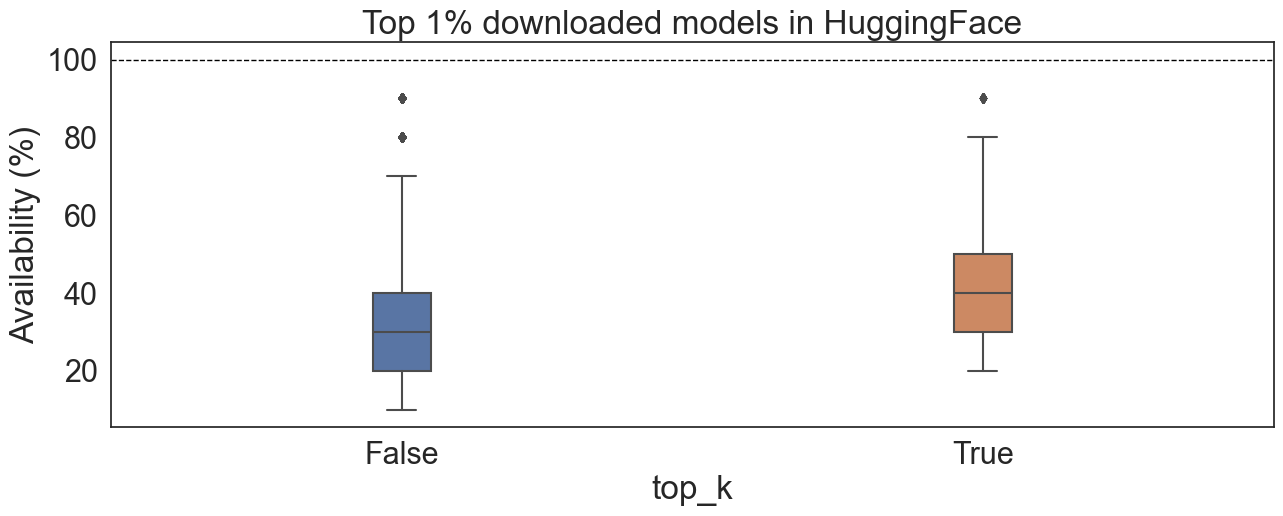

In [95]:
K = 1
M = np.percentile(new_df.downloads, 100-K)
new_df["top_k"] = [True if v >= M else False for v in new_df.downloads]
plt.figure(figsize=(15, 5))   
sns.boxplot(x="top_k", y="available", data=new_df, width =0.1)
plt.title("Top 1% downloaded models in HuggingFace")
plt.ylabel("Availability (%)")
plt.axhline(100, ls="--", color="black", linewidth=1)


/Users/frapierri/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


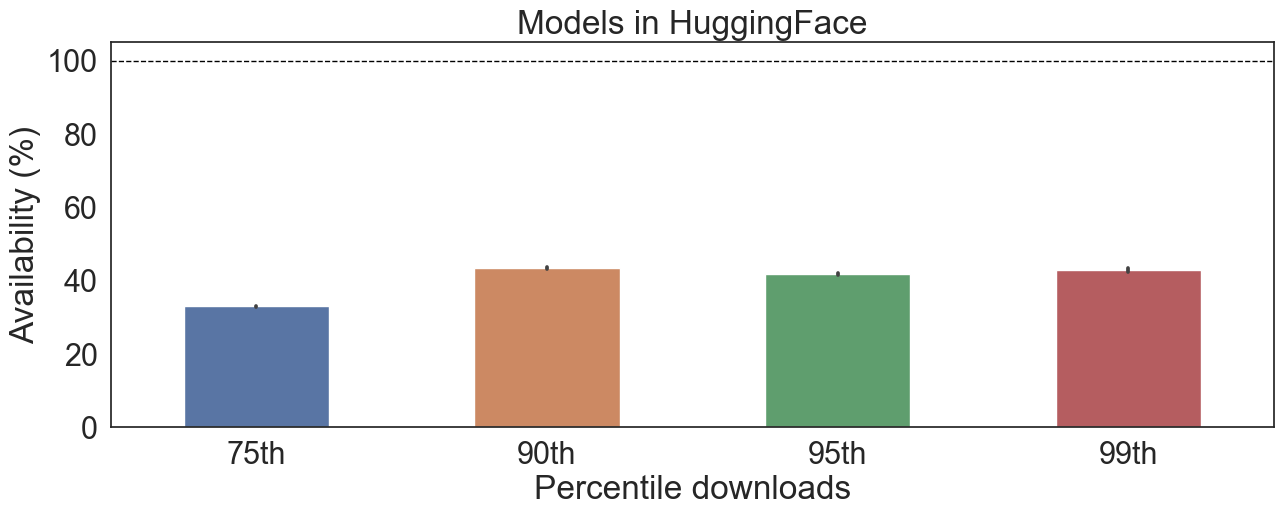

In [96]:
plt.figure(figsize=(15, 5))   
#sns.boxplot(new_df["available"], width =0.1, )
sns.barplot(x="downloads_binned", y="available", data=new_df, width=0.5)
plt.title("Models in HuggingFace")
plt.ylabel("Availability (%)")
plt.xticks(range(4), ["75th", "90th", "95th", "99th"])
plt.xlabel("Percentile downloads")
plt.axhline(100, ls="--", color="black", linewidth=1)

In [97]:
plot_df = pd.DataFrame()
values = []
labels = []
downloads = []
devs = []
largest = dict()
for k in [50, 100, 500, 1000, 5000]:
    largest[k] = new_df.nlargest(k, "downloads")["downloads"].values[-1]
for ix, row in new_df.iterrows():
    v = row.available
    values.append(v)
    labels.append("All")
    downloads.append(row.downloads)
    devs.append(row.developers)
    for k in [50, 100, 500, 1000, 5000]:
        if row.downloads >= largest[k]:
            values.append(v)
            labels.append("Top " + str(k))
            downloads.append(row.downloads)
            devs.append(row.developers)
    if row.downloads == 0:
        values.append(v)
        labels.append("Downloads = 0")
        downloads.append(row.downloads)
        devs.append(row.developers)

In [98]:
plot_df = pd.DataFrame()
plot_df["value"] = values
plot_df["label"] = labels
plot_df["downloads"] = downloads
plot_df["developers"] = devs

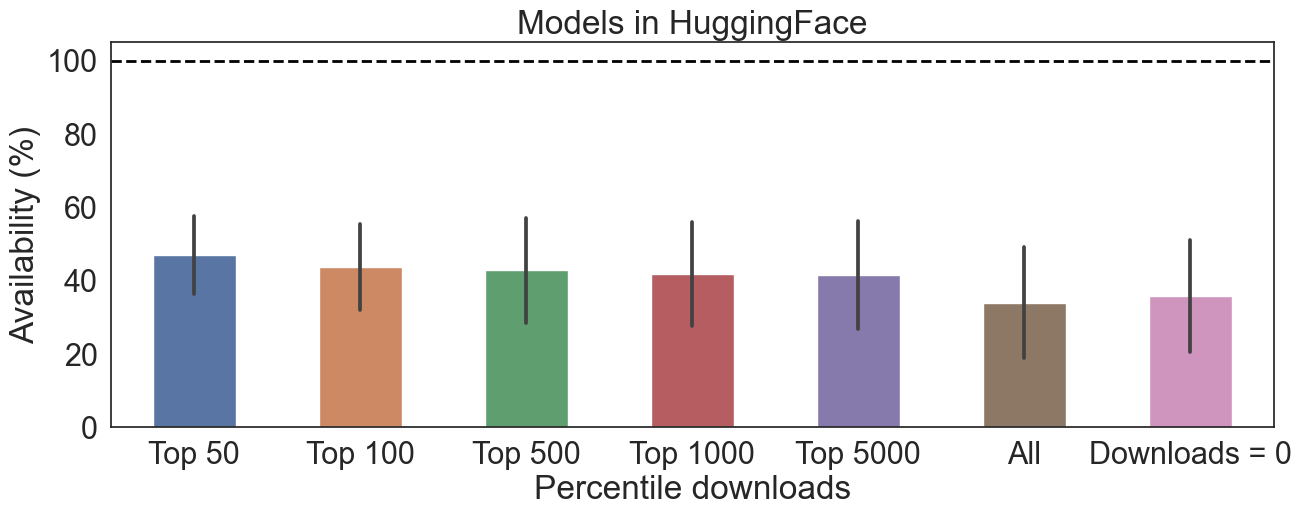

In [99]:
plt.figure(figsize=(15, 5))   
#sns.boxplot(new_df["available"], width =0.1, )
sns.barplot(x="label", y="value", errorbar=('sd'), 
            order = ["Top 50", "Top 100", "Top 500", "Top 1000", "Top 5000", "All", "Downloads = 0"],
            data=plot_df, width=0.5)
plt.title("Models in HuggingFace")
plt.ylabel("Availability (%)")
# plt.xticks(range(4), ["75th", "90th", "95th", "99th"])
plt.xlabel("Percentile downloads")
#plt.axhline(100, ls="--", color="black", linewidth=1)
plt.axhline(100, ls="--", color="black", linewidth=2)

(0.0, 100.0)

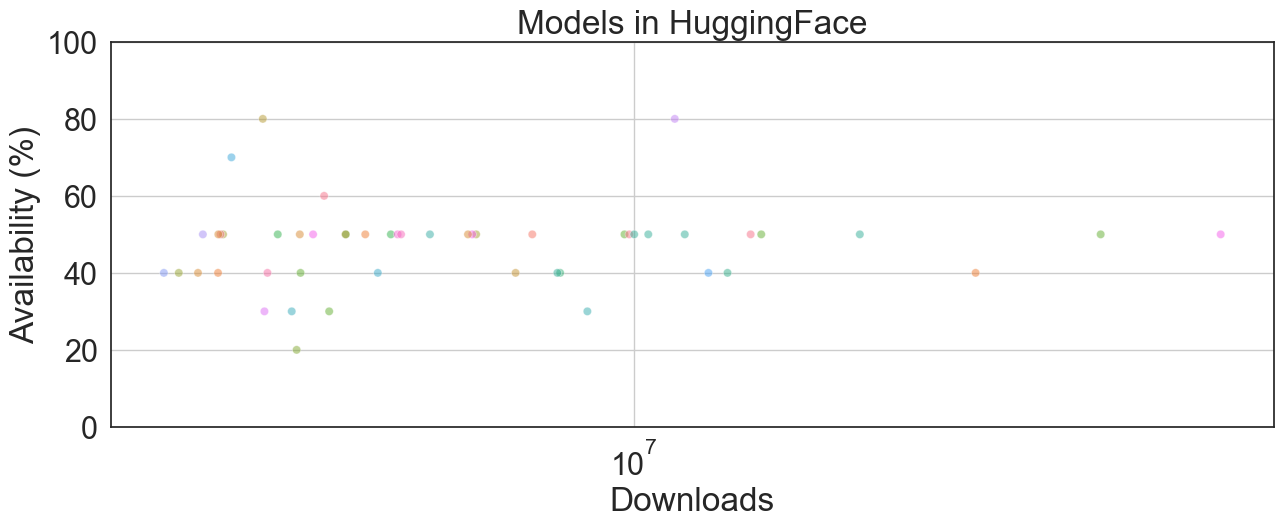

In [100]:
plt.figure(figsize=(15, 5))   
data = plot_df[plot_df.label == "Top 50"]
#sns.boxplot(new_df["available"], width =0.1, )
sns.scatterplot(x="downloads", y="value", 
            data=data,
                alpha = 0.5,
           hue = "developers", legend = False)
plt.title("Models in HuggingFace")
plt.ylabel("Availability (%)")
# plt.xticks(range(4), ["75th", "90th", "95th", "99th"])
plt.xlabel("Downloads")
plt.xscale("log")
#plt.yscale("log")
plt.grid()
plt.ylim(0, 100)
#plt.axhline(100, ls="--", color="black", linewidth=1)


In [101]:
names = df[df.downloads.astype(int).isin(data.downloads)]["name"]

,name,version,numberOfParameters,quantization,architecture,languages,modelCreator,licenseToUse,libraryFramework,contextLength,...,openSource,uri,fineTuned,carbonEmission [CO2eq tons],tokenizer,likes,downloads,tasks,dataset,metrics
104,distilgpt2,None,None,None,None,['en'],None,apache-2.0,"['transformers', 'pytorch', 'tf', 'jax', 'rust...",None,...,True,1910.01108,None,149200,None,411,3765479,['text-generation'],['openwebtext'],None
108,gpt2,None,None,None,None,['en'],None,mit,"['transformers', 'pytorch', 'tf', 'jax', 'rust...",None,...,True,10.57967/hf/0039,None,None,None,2204,7258211,['text-generation'],None,None
5738,opt-125m,None,None,None,None,['en'],None,other,"['transformers', 'pytorch', 'tf', 'jax']",None,...,True,2205.01068,None,None,None,151,4287113,['text-generation'],None,None
79237,Phi-3-mini-4k-instruct,None,None,None,None,['en'],None,mit,"['transformers', 'safetensors']",None,...,True,None,None,None,None,1009,2530031,['text-generation'],None,None
115288,grabbe-ai,None,None,None,None,['de'],None,gemma,"['transformers', 'pytorch', 'safetensors', 'gg...",None,...,True,None,None,None,None,6,6885923,['text-generation'],['grabbe-gymnasium-detmold/grabbeai'],None
121028,Meta-Llama-3.1-8B-Instruct,None,None,None,meta-llama/Meta-Llama-3.1-8B,"['en', 'de', 'fr', 'it', 'pt', 'hi', 'es', 'th']",meta-llama,llama3.1,"['transformers', 'safetensors', 'pytorch']",None,...,True,2204.05149,True,None,None,2270,3103570,['text-generation'],None,None
136524,t5-base,None,None,None,None,"['en', 'fr', 'ro', 'de']",None,apache-2.0,"['transformers', 'pytorch', 'tf', 'jax', 'rust...",None,...,True,1805.12471,None,None,None,547,2738494,"['summarization', 'translation']",['c4'],None
136526,t5-small,None,None,None,None,"['en', 'fr', 'ro', 'de']",None,apache-2.0,"['transformers', 'pytorch', 'tf', 'jax', 'rust...",None,...,True,1805.12471,None,None,None,315,6080649,"['summarization', 'translation']",['c4'],None
137842,opus-mt-zh-en,None,None,None,None,"['zh', 'en']",None,cc-by-4.0,"['transformers', 'pytorch', 'tf', 'rust']",None,...,True,None,None,None,None,419,2381286,['translation'],None,None
141359,bart-large-cnn,None,None,None,None,['en'],None,mit,"['transformers', 'pytorch', 'tf', 'jax', 'rust...",None,...,True,1910.13461,None,None,None,1103,4028935,['summarization'],['cnn_dailymail'],None


In [114]:
api = HfApi()
names = df[df.downloads.astype(int).isin(data.downloads)]["name"]
devs = df[df.downloads.astype(int).isin(data.downloads)]["developers"]

new_downloads = []
for n,d in zip(names, devs):
    d = eval(d)[0]
    for m in api.list_models(filter=n, full=True, cardData = True):
        if m.author == d:
            print(m)

Model Name: openai-community/gpt2, Tags: ['transformers', 'pytorch', 'tf', 'jax', 'tflite', 'rust', 'onnx', 'safetensors', 'gpt2', 'text-generation', 'exbert', 'en', 'doi:10.57967/hf/0039', 'license:mit', 'autotrain_compatible', 'text-generation-inference', 'endpoints_compatible', 'region:us'], Task: text-generation
Model Name: openai-community/gpt2-large, Tags: ['transformers', 'pytorch', 'tf', 'jax', 'rust', 'onnx', 'safetensors', 'gpt2', 'text-generation', 'en', 'arxiv:1910.09700', 'license:mit', 'autotrain_compatible', 'text-generation-inference', 'endpoints_compatible', 'region:us'], Task: text-generation
Model Name: openai-community/gpt2-medium, Tags: ['transformers', 'pytorch', 'tf', 'jax', 'rust', 'onnx', 'safetensors', 'gpt2', 'text-generation', 'en', 'arxiv:1910.09700', 'license:mit', 'autotrain_compatible', 'text-generation-inference', 'endpoints_compatible', 'region:us'], Task: text-generation
Model Name: openai-community/gpt2-xl, Tags: ['transformers', 'pytorch', 'tf', 'ja

KeyboardInterrupt: 

In [3]:
api = HfApi()
api.model_info(repo_id = "openai-community/gpt2", expand="downloads_all_time")

TypeError: HfApi.model_info() got an unexpected keyword argument 'expand'